# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [345]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, min, max, avg, split, round
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window

from pyspark.sql.types import IntegerType, TimestampType
import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

In [33]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

### Common Functions

In [381]:
# Set plot's figure size
def set_plot_size(width, height):
    return plt.figure(figsize = [width, height]);

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [34]:
# Load dataset
path = "data/mini_sparkify_event_data.json"
data = spark.read.json(path)
original_count = data.count()

In [35]:
# Dataset size
print(f'Row count: {original_count}')
print(f'Column count: {len(data.columns)}')

Row count: 286500
Column count: 18


In [36]:
# Any duplicate rows? - No
print(f'Duplicate rows: {data.count() - data.dropDuplicates().count()}')

Duplicate rows: 0


In [37]:
# Filter by missing value (either null of empty - if string)
def filter_missing(data, name):
    return data.where((col(name).isNull()) | (col(name) == ''))

# Show count of missing values for all columns in the dataset
def show_missing(data):
    for field in data.schema:
        print(f'{field.name}: {filter_missing(data, field.name).count()}')
        
# Are 8346 missing values in user's column firstName, gender, lastName, location, registration, userAgent, userId correlated 
# occurring in the same rows? - Yes
class Missing:
    missing_data = None
    
    def __init__(self, data):
        self.missing_data = data
        
    def filter_missing(self, name):
        self.missing_data = filter_missing(data, name) 
        return self  
    
m = Missing(data) \
    .filter_missing('userId') \
    .filter_missing('firstName') \
    .filter_missing('lastName') \
    .filter_missing('gender') \
    .filter_missing('location') \
    .filter_missing('registration') \
    .filter_missing('userAgent')
print(f'Missing count: {m.missing_data.count()}')

Missing count: 8346


In [37]:
# Remove rows with missing users
data = data.where(~((col('userId').isNull()) | (col('userId') == '')))

In [38]:
# Check count of deleted rows
original_count - data.count()

8346

In [39]:
# Exclude non-relevant columns
data = data.drop('firstName')
data = data.drop('lastName')
data = data.drop('method')

In [40]:
data = data.withColumn('regDate', (col('registration') / 1000.0).cast(TimestampType()))
data = data.withColumn('tsDate', (col('ts') / 1000.0).cast(TimestampType()))
data.take(3)

[Row(artist='Martha Tilston', auth='Logged In', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', regDate=datetime.datetime(2018, 9, 29, 0, 22, 42), tsDate=datetime.datetime(2018, 10, 1, 2, 1, 57)),
 Row(artist='Five Iron Frenzy', auth='Logged In', gender='M', itemInSession=79, length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', regDate=datetime.datetime(2018, 9, 30, 20, 20, 30), tsDate=datetime.datetime(2018, 10, 1, 2, 3)),
 Row(artist='Adam Lambert', auth='Logged In', gender='M', item

In [41]:
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- regDate: timestamp (nullable = true)
 |-- tsDate: timestamp (nullable = true)



In [10]:
# NOT WORKING TIMESTAMP CONVERSION
'''to_date = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0), TimestampType())
data = data.withColumn('tsDate', to_date('ts'))
data = data.withColumn('regDate', to_date('registration'))'''

In [42]:
data = data.withColumn('city', split(data['location'], ',')[0])
data = data.withColumn('state', split(data['location'], ',')[1])
data = data.drop('location')

In [43]:
data.take(1)

[Row(artist='Martha Tilston', auth='Logged In', gender='M', itemInSession=50, length=277.89016, level='paid', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', regDate=datetime.datetime(2018, 9, 29, 0, 22, 42), tsDate=datetime.datetime(2018, 10, 1, 2, 1, 57), city='Bakersfield', state=' CA')]

In [44]:
# Schema after the cleaning is done
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- regDate: timestamp (nullable = true)
 |-- tsDate: timestamp (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [51]:
# Count of unique users
data.select("userId").dropDuplicates().count()

225

In [53]:
# Count of unique sessions
data.select("sessionId").dropDuplicates().count()

2312

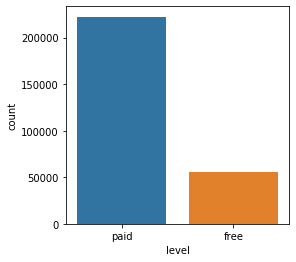

In [173]:
# Levels
set_plot_size(4, 4)
df = data.select('level').toPandas()
sb.countplot(data = df, x = 'level');

+-------------------------+
|page                     |
+-------------------------+
|About                    |
|Add Friend               |
|Add to Playlist          |
|Cancel                   |
|Cancellation Confirmation|
|Downgrade                |
|Error                    |
|Help                     |
|Home                     |
|Logout                   |
|NextSong                 |
|Roll Advert              |
|Save Settings            |
|Settings                 |
|Submit Downgrade         |
|Submit Upgrade           |
|Thumbs Down              |
|Thumbs Up                |
|Upgrade                  |
+-------------------------+



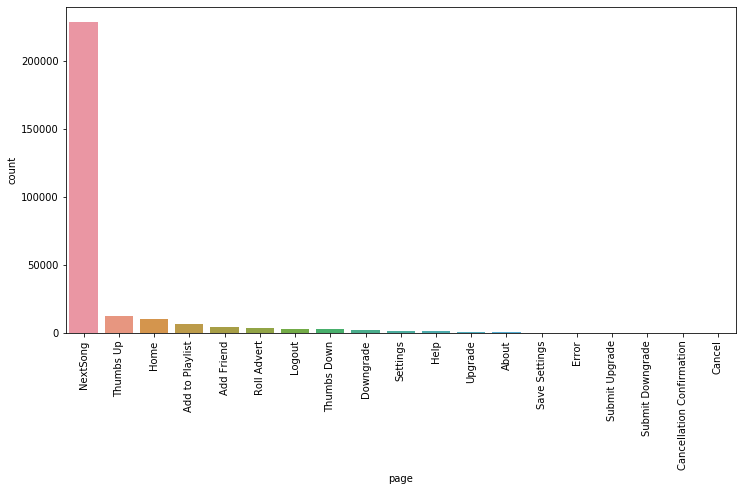

In [424]:
# Pages
data.select('page').dropDuplicates().sort('page').show(truncate=False)

set_plot_size(12, 6)
df = data.select('page').toPandas()
sb.countplot(data = df, x = 'page', order = df['page'].value_counts().index);
plt.xticks(rotation = 90);

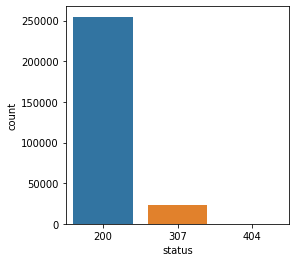

In [178]:
# Statuses 
set_plot_size(4, 4)
df = data.select('status').toPandas()
sb.countplot(data = df, x = 'status');

In [170]:
df['status'].value_counts()

200    254718
307     23184
404       252
Name: status, dtype: int64

+-------+-----------------+
|summary|            count|
+-------+-----------------+
|  count|              225|
|   mean|          1236.24|
| stddev|1329.531716432519|
|    min|                6|
|    max|             9632|
+-------+-----------------+



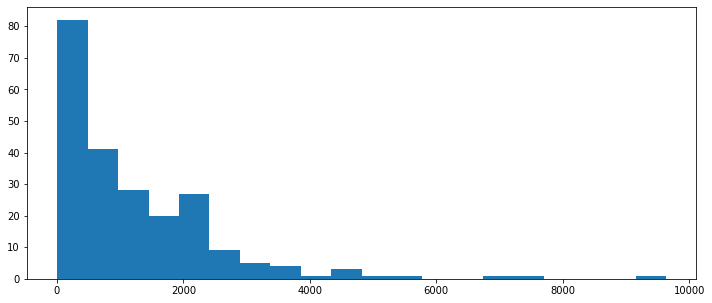

In [181]:
# Logs per user
data.groupby('userId').count().describe('count').show()

# Show histogram
set_plot_size(12, 5)
df = data.groupby('userId').count().toPandas()
plt.hist(data = df, x = 'count', bins = 20);

A it was expected, the distribution of user logs is *right-skewed*.

In [168]:
# Sessions per user
df = data.groupby('userId', 'sessionId').count().toPandas()
df['userId'].value_counts().describe()

count    225.000000
mean      14.115556
std       14.646885
min        1.000000
25%        6.000000
50%       10.000000
75%       18.000000
max      107.000000
Name: userId, dtype: float64

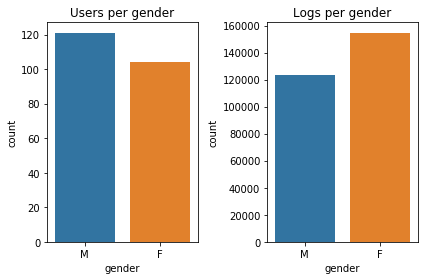

In [234]:
# Users & logs per gender
fig, axes = plt.subplots(nrows=1, ncols=2)

df_logs = data.select('gender').toPandas()
df_users = data.groupby('userId', 'gender').count().toPandas()

# users per gender
plt.subplot(1, 2, 1)
sb.countplot(data = df_users, x = 'gender', order = ['M','F']).set_title('Users per gender')
plt.title = 'hello'

# logs per gender
plt.subplot(1, 2, 2)
sb.countplot(data = df_logs, x = 'gender', order = ['M','F']).set_title('Logs per gender');

fig.tight_layout();


### Songs, Artists

In [414]:
# Top 10 songs
data.where(data.song.isNotNull()) \
    .groupby('song') \
    .count() \
    .sort(desc('count')) \
    .show(10)

+--------------------+-----+
|                song|count|
+--------------------+-----+
|      You're The One| 1153|
|                Undo| 1026|
|             Revelry|  854|
|       Sehr kosmisch|  728|
|Horn Concerto No....|  641|
|Dog Days Are Over...|  574|
|             Secrets|  466|
|        Use Somebody|  459|
|              Canada|  435|
|             Invalid|  424|
+--------------------+-----+
only showing top 10 rows



In [415]:
# Top 10 artists
data.where(data.song.isNotNull()) \
    .groupby('artist') \
    .count() \
    .sort(desc('count')) \
    .show(10)

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
|              Eminem|  953|
+--------------------+-----+
only showing top 10 rows



### Session

count     2312.000000
mean      8964.957093
std      20525.300525
min          0.000000
25%         91.850000
50%        279.900000
75%       1120.075000
max      87739.100000
Name: duration, dtype: float64


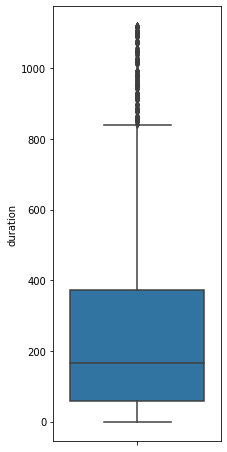

In [407]:
# Session duration (in minutes)
df = data.groupby('sessionId') \
    .agg(((max('ts') - min('ts'))/60000).alias('duration')) \
    .select('sessionId', round(col('duration'), 1).alias('duration')) \
    .toPandas()

print(df.duration.describe())

# boxplot 75% of sessions
max_duration = 1121
set_plot_size(3, 8)
sb.boxplot(data = df[df.duration < 1121], y = 'duration');

In [293]:
# Check a single session where the user has performed 'Submit Downgrade' action 
data.where(col('page') == 'Submit Downgrade').select('userId', 'sessionId', 'page').show(5)

sessionId = 313

# user data
data.where(col('sessionId') == sessionId).select('userId', 'regDate', 'sessionId').show(1)

cols = ['tsDate', 'auth', 'level', 'page', 'status', 'song', 'artist', 'length']
data.where(col('sessionId') == sessionId).select(cols).show()

+------+---------+----------------+
|userId|sessionId|            page|
+------+---------+----------------+
|   131|      249|Submit Downgrade|
|    38|      313|Submit Downgrade|
|   141|      479|Submit Downgrade|
|    30|      532|Submit Downgrade|
|    20|      378|Submit Downgrade|
+------+---------+----------------+
only showing top 5 rows

+------+-------------------+---------+
|userId|            regDate|sessionId|
+------+-------------------+---------+
|    38|2018-09-16 19:59:17|      313|
+------+-------------------+---------+
only showing top 1 row

+-------------------+---------+-----+----------------+------+--------------------+--------------------+---------+
|             tsDate|     auth|level|            page|status|                song|              artist|   length|
+-------------------+---------+-----+----------------+------+--------------------+--------------------+---------+
|2018-10-02 22:37:00|Logged In| paid|        NextSong|   200|           Te Quiero|   Jose 

### Churned users

In [459]:
# Count churned users - must fulfill te following 2 conditions:
#   1. User must interact with 'Submit Downgrade' page OR 'Cancellation Confirmation' page
#   

users = data \
    .where(data.page.isin(['Submit Downgrade', 'Cancellation Confirmation']) & (data.level == 'paid')) \
    .groupby('userId') \
    .agg(min('ts').alias('timestamp_min'), max('ts').alias('timestamp_max')) \
    .collect()

# list of userIds
uids = [x.userId for x in users];

is_candidate = udf(lambda x: x.isin(uids))


In [463]:
cols = ['userId', 'regDate', 'sessionId', 'tsDate', 'auth', 'level', 'page', 'status']
data.where(data.userId.isin(uids)) \
    .groupby('userId') \
    .count() \
    .sort('count') \
    .show()
    #.select(cols).show(500)

+------+-----+
|userId|count|
+------+-----+
|   122|   62|
|    32|  108|
|300007|  143|
|     3|  254|
|300004|  262|
|100014|  310|
|   129|  412|
|    73|  457|
|100023|  494|
|    18|  513|
|100007|  520|
|200024|  552|
|100012|  600|
|200017|  620|
|100025|  623|
|    24|  630|
|100016|  638|
|200019|  639|
|100009|  671|
|    11|  848|
+------+-----+
only showing top 20 rows



In [465]:
cols = ['userId', 'regDate', 'sessionId', 'tsDate', 'auth', 'level', 'page', 'status']
data.where(data.userId == 122).select(cols).show(500)

+------+-------------------+---------+-------------------+---------+-----+--------------------+------+
|userId|            regDate|sessionId|             tsDate|     auth|level|                page|status|
+------+-------------------+---------+-------------------+---------+-----+--------------------+------+
|   122|2018-08-29 01:25:05|      403|2018-10-04 14:47:15|Logged In| free|                Home|   200|
|   122|2018-08-29 01:25:05|      403|2018-10-04 14:47:16|Logged In| free|              Logout|   307|
|   122|2018-08-29 01:25:05|      611|2018-10-10 14:12:18|Logged In| free|                Home|   200|
|   122|2018-08-29 01:25:05|      611|2018-10-10 14:14:24|Logged In| free|            NextSong|   200|
|   122|2018-08-29 01:25:05|      611|2018-10-10 14:17:04|Logged In| free|            NextSong|   200|
|   122|2018-08-29 01:25:05|      611|2018-10-10 14:19:15|Logged In| free|            NextSong|   200|
|   122|2018-08-29 01:25:05|      611|2018-10-10 14:24:24|Logged In| free

In [ ]:
# get last log
cols = ['userId', 'regDate', 'sessionId', 'tsDate', 'auth', 'level', 'page', 'status']
data.where(data.userId.isin(uids)) \
    .groupby('userId') \
    .agg(max())
    .show()
    #.select(cols).show(500)

In [487]:
from pyspark.sql.window import Window

w =  Window.partitionBy(data.userId).orderBy(col('ts').desc())

In [496]:
from pyspark.sql.functions import row_number

data2 = data.select('userId', 'regDate', 'sessionId', 'tsDate', 'auth', 'level', 'page', 'status',
        row_number().over(w).alias("rown"))

In [505]:
data2.where((data2.rown == 1) \
            & (data2.level == 'free') \
            & (data2.userId.isin(uids))).show()

+------+-------------------+---------+-------------------+---------+-----+--------------------+------+----+
|userId|            regDate|sessionId|             tsDate|     auth|level|                page|status|rown|
+------+-------------------+---------+-------------------+---------+-----+--------------------+------+----+
|    35|2018-09-16 01:16:52|     2354|2018-11-30 11:24:09|Logged In| free|         Roll Advert|   200|   1|
|100008|2018-09-20 12:44:31|      201|2018-11-27 17:13:39|Logged In| free|              Logout|   307|   1|
|100025|2018-07-26 19:19:29|      129|2018-10-23 14:52:32|Cancelled| free|Cancellation Conf...|   200|   1|
|    61|2018-09-17 14:48:58|     2345|2018-11-28 18:54:04|Logged In| free|                Home|   200|   1|
|   131|2018-08-01 07:45:30|     2281|2018-11-30 04:21:23|Logged In| free|                Home|   200|   1|
|300004|2018-08-17 15:44:05|      267|2018-11-14 23:41:25|Logged In| free|           Thumbs Up|   307|   1|
|100009|2018-09-19 19:00:37|

In [514]:
data2.where((data2.rown == 1) & (data2.userId == 122)).show(500)

+------+-------------------+---------+-------------------+---------+-----+--------------------+------+----+
|userId|            regDate|sessionId|             tsDate|     auth|level|                page|status|rown|
+------+-------------------+---------+-------------------+---------+-----+--------------------+------+----+
|   122|2018-08-29 01:25:05|     1029|2018-10-20 21:01:08|Cancelled| paid|Cancellation Conf...|   200|   1|
+------+-------------------+---------+-------------------+---------+-----+--------------------+------+----+



In [530]:
# GET CHURNED USERS
users = data \
    .where(data.page.isin(['Submit Downgrade', 'Cancellation Confirmation'])) \
    .select('userId') \
    .dropDuplicates() \
    .collect()

# list of userIds
uids = [x.userId for x in users];

# Window
w =  Window.partitionBy(data.userId).orderBy(col('ts').desc())
data2 = data.select('userId', 'regDate', 'sessionId', 'tsDate', 'auth', 'level', 'page', 'status',
        row_number().over(w).alias("rown"))
    
# final query
data2 \
    .where(data2.rown == 1) \
    .where(data2.userId.isin(uids)) \
    .where((data2.level == 'free') | (data2.page == 'Cancellation Confirmation')) \
    .count()



67

In [ ]:
overUser = window.partitionBy('userId')
w = data.withColumn(
  "rown", array_contains('userId', 'tsDate', 'auth', 'level', 'page', 'status') over overUser).withColumn(
  "total_salary_in_dep", sum('salary) over overCategory)
df.show()

In [ ]:
to_date = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0), TimestampType())
data = data.withColumn('tsDate', to_date('ts'))
data = data.withColumn('regDate', to_date('registration'))



In [440]:
users[0]

Row(userId='125', timestamp_min=1539318918000, timestamp_max=1539318918000)

In [ ]:
df = data.groupby('sessionId') \
    .agg(((max('ts') - min('ts'))/60000).alias('duration')) \
    .select('sessionId', round(col('duration'), 1).alias('duration')) \
    .toPandas()

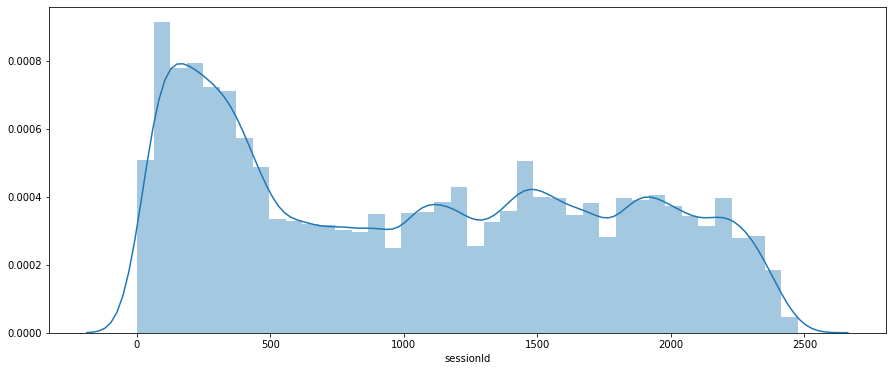

In [41]:
plt.figure(figsize=(15,6))
sb.distplot(df['sessionId'], bins=40)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.